In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import birdsonganalysis as bsa
from os.path import join, exists, basename
from scipy.io import wavfile
import pickle
import json
from pprint import pprint
from IPython.display import Audio, display, Markdown
import warnings
import sys
import pandas

sys.path.append('../model/')

from song_fitter import SongModel, get_scores
import synth
from synth import synthesize

sns.set_palette('colorblind')

In [2]:
path = '../model/res/test_time_170406_152547/'
if exists(join(path, 'aborted.txt')):
    warnings.warn('Aborted run')
if not exists(join(path, 'data.pkl')):
    warnings.warn('Run is not finished')

/home/ecoffet/.virtualenvs/birdsongs/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Run is not finished


In [3]:
sr, tutor = wavfile.read(join(path, 'tutor.wav'))
with open(join(path, 'params.json'), 'r') as f:
    run_param = json.load(f)

In [4]:
try:
    with open(join(path, 'desc.md'), 'r') as f:
        display(Markdown( '> ' + '\n> '.join(f.read().split("\n"))))
except FileNotFoundError:
    print('No desc for this run.')

> # Run description
> 
> ## Goals
> 
> - Test if good results even with padded
> 
> ## What have changed compared to previous runs?
> 
> -
> 
> ## Expected Results (Success condition)
> 
> -
> 
> <!-- ## Notes -->
> 

In [5]:
out = '| key | value |\n|---|---|\n' + '\n'.join(['| {} | {} |'.format(key, run_param[key]) for key in sorted(run_param.keys())])
display(Markdown(out))

| key | value |
|---|---|
| commit | 6dddbcbf537ce8ee42c6fb566a06ec29d0d37079 |
| comp | linalg |
| concurrent | 3 |
| days | 50 |
| dlm | optimise_gesture_padded |
| iter_per_train | 20 |
| name | test_time |
| nlm | mutate_best_models_elite |
| replay | 5 |
| seed | 1491485147 |
| train_per_day | 100 |
| tutor | ../data/ba_example.wav |

In [6]:
with open(join(path, 'prior_max_min_dev.json')) as f:
    print(f.read())

{
  "#comment": [
  "def of sin param : (a * t + b) * sin((t + phase) * f * 2 * pi)",
  "Format of each list",
  "```",
  "#alpha",
  "a, b, phase, f  #sin 1",
  "a, b, phase, f  #sin 2",
  "a, b, phase, f  #sin 3",
  "cst",
  "#beta",
  "a, b, phase, f, cst",
  "```",
  "really ugly way to comment in json, sorry."],
  "prior": [
    0, 0, 3.141592653589793, 15,
    0, 0, 0.39269908169872414, 45,
    0, 0, 0, 5000,
    0.0,
    0, 0, 0, 0, 0
  ],
  "mins": [
    -50, 0, -3.141592653589793, 0,
    -50, 0, -3.141592653589793, 0,
    -50, 0, -3.141592653589793, 0,
    -5,
    -50, 0, -3.141592653589793, 0, -3
  ],
  "maxs": [
    50, 4, 3.141592653589793, 40000,
    50, 4, 3.141592653589793, 40000,
    50, 5, 3.141592653589793, 40000,
    10,
    50, 3, 3.141592653589793, 1000, 2
  ],
  "dev": [
    0.1,   0.1,   0.05,  1,
    0.05,  0.05,  0.05,  1,
    0.001, 0.001, 0.005, 100,
    0.2,
    0.05, 0.01, 0.05, 1, 0.005
  ]
}



In [7]:
with sns.plotting_context('paper'):
    fig = plt.figure(figsize=(16, 5))
    ax = fig.gca()
    ax.plot(np.r_[0:len(tutor)//44100:len(tutor)*1j], tutor)
    ax.set_yticks([])
    ax.set_xlim((0, len(tutor)//44100))
    plt.show()

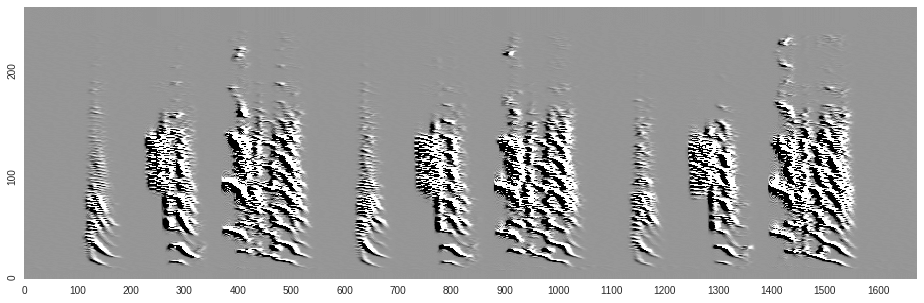

In [8]:
tspec = bsa.spectral_derivs(tutor, 256, 40, 1024)
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
plt.show(fig)

In [9]:
outputs = []
not_found = False
try:
    for i in range(run_param['concurrent']):
        outputs.append(wavfile.read(join(path, 'out_{}.wav'.format(i)))[1])
except FileNotFoundError:
    not_found = True
with open(join(path, 'data_cur.pkl'), 'rb') as f:
    songlog = pickle.load(f)
    root_data = [item[1] for item in songlog if item[0] == 'root']
    rd = pandas.DataFrame(root_data)
    smodels = rd['songs'].iloc[-1]
    if not_found:
        outputs = [smodel.gen_sound() for smodel in smodels]

In [10]:
display(Audio(tutor, rate=44100))

In [11]:
for output in outputs:
    display(Audio(output, rate=44100))

In [12]:
run = False  # Disabled because very long.
if run:
    for out in outputs:
        sim = bsa.similarity(out, tutor)
        bsa.similarity_plot(sim, out, tutor)
        print(sim['similarity'])

In [13]:
tfeat = bsa.all_song_features(tutor, 44100, freq_range=256, fft_size=1024, fft_step=40)
sfeat = bsa.all_song_features(outputs[0], 44100, freq_range=256, fft_size=1024, fft_step=40)

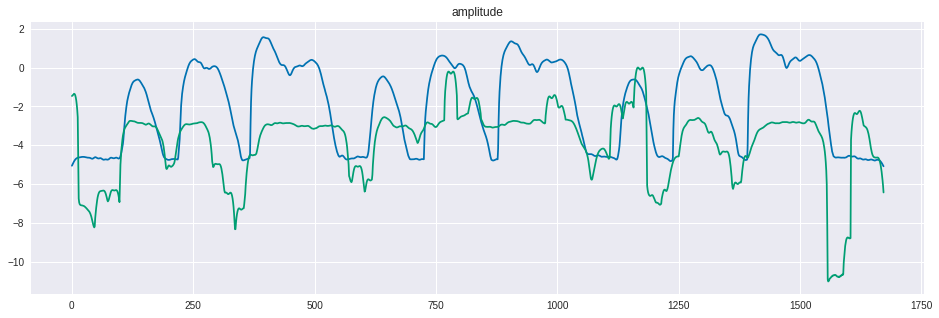

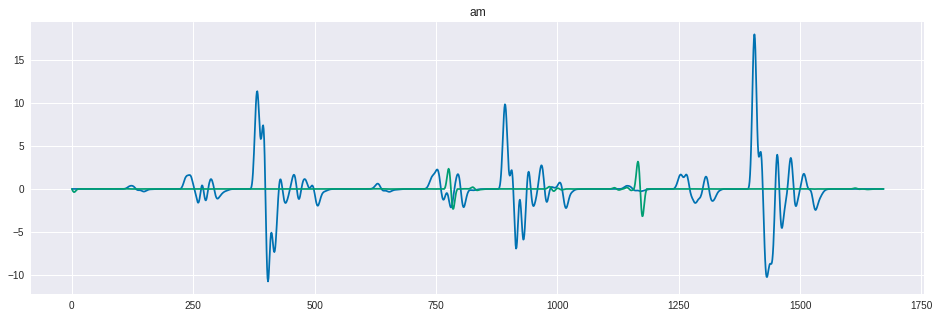

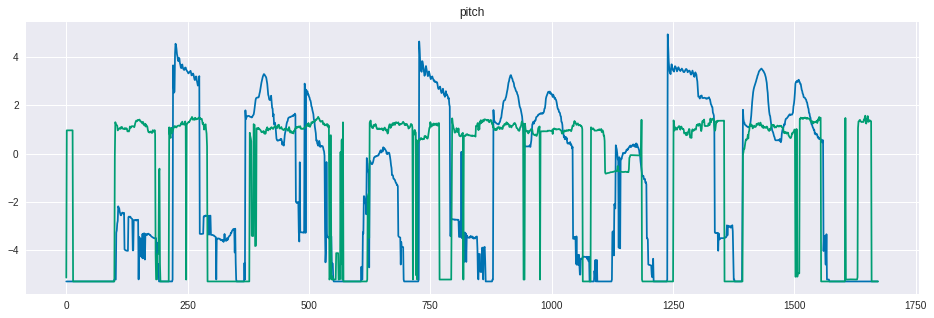

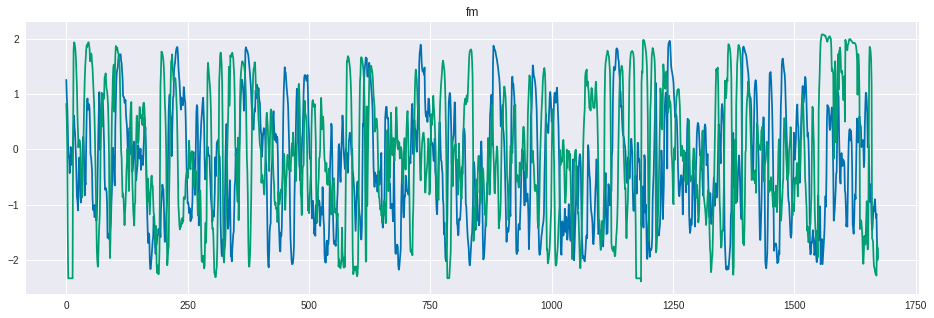

In [14]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

ntfeat = bsa.normalize_features(tfeat)
nsfeat = bsa.normalize_features(sfeat)

for fname in tfeat:
    plt.figure(figsize=(16, 5))
    plt.plot(running_mean(ntfeat[fname], 1))
    plt.plot(running_mean(nsfeat[fname], 1))
    plt.title(fname)
    plt.show()

In [15]:
len(smodels[1].gestures)

36

In [16]:
ab = smodels[0].gen_alphabeta()

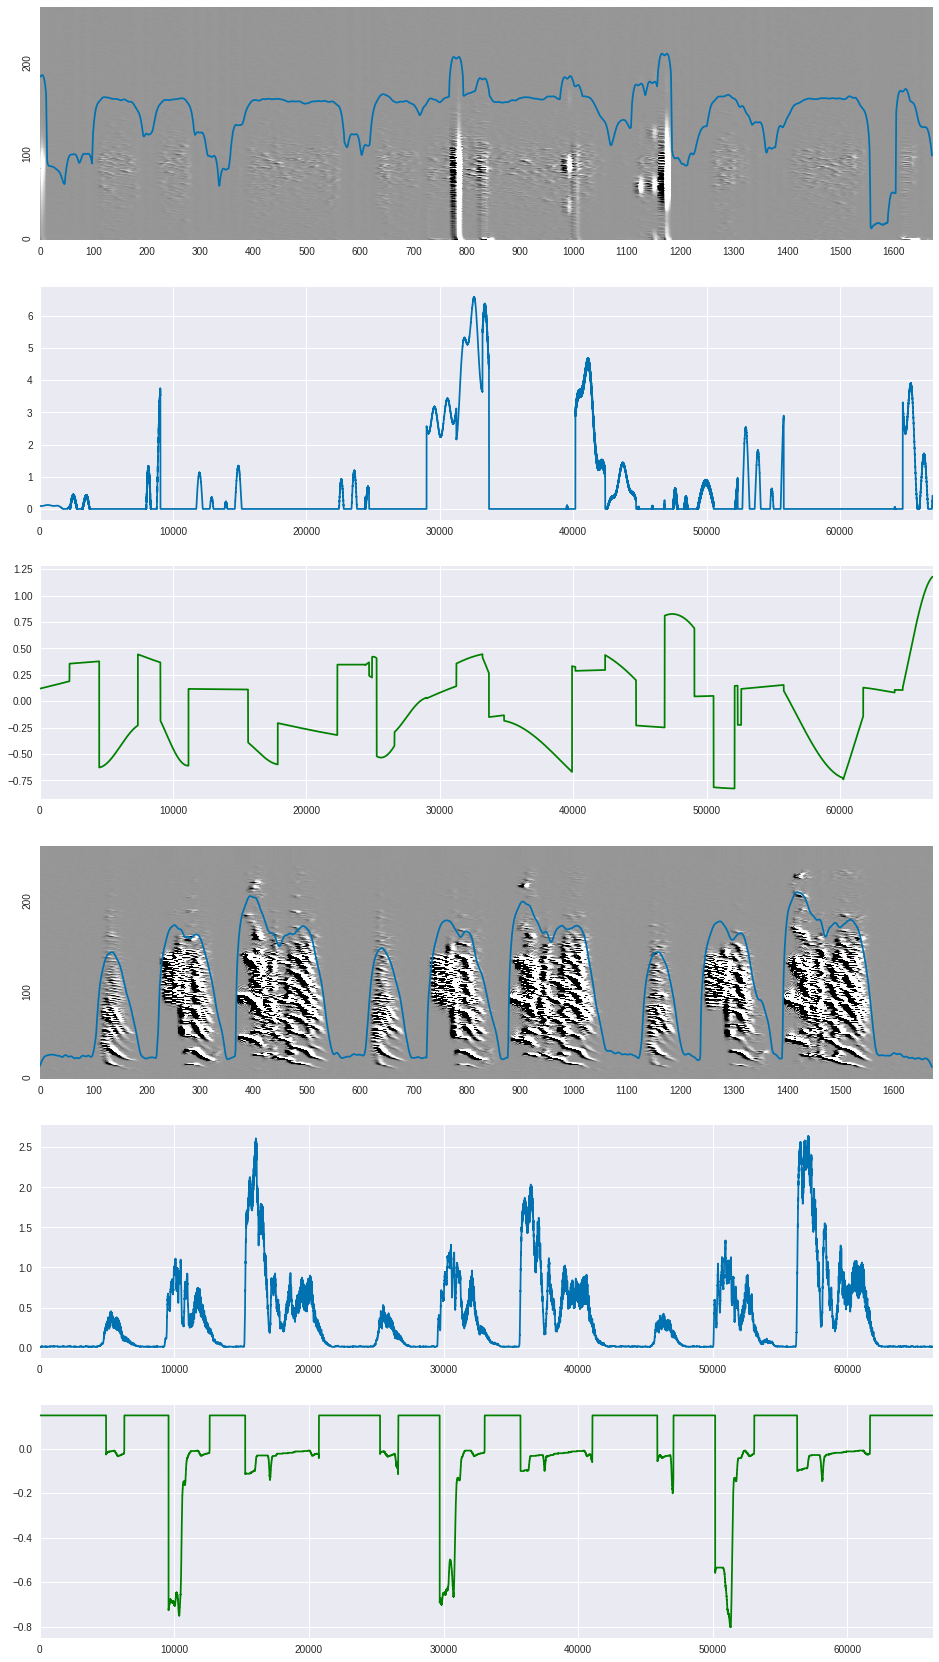

In [17]:


fig, axs = plt.subplots(6, 1, figsize=(16, 5*6))
ospec = bsa.spectral_derivs(outputs[0], 256, 40, 1024)
bsa.spectral_derivs_plot(ospec, contrast=0.01, ax=axs[0])
bsa.plot_over_spec(sfeat['amplitude'], ax=axs[0])
axs[0].set_xlim(0, ospec.shape[0])
axs[1].plot(ab[:, 0])
axs[1].set_xlim((0, ab.shape[0]))
axs[2].plot(ab[:, 1], color="g")
axs[2].set_xlim((0, ab.shape[0]))
bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=axs[3])
bsa.plot_over_spec(tfeat['amplitude'], ax=axs[3])

tutor_params = np.loadtxt('../data/{}_ab.dat'.format(basename(run_param['tutor']).split('.')[0]))
axs[4].plot(tutor_params[:, 0])
axs[4].set_xlim((0, tutor_params.shape[0]))
axs[5].plot(tutor_params[:, 1], c="g")
axs[5].set_xlim((0, tutor_params.shape[0]))


for i, gesture in enumerate(smodels[0].gestures):
    start = gesture[0]
    #axs[0].axvline(x=start/40, color="k", linewidth=1)
    #axs[1].axvline(x=start, color="k", linewidth=1)
    #axs[2].axvline(x=start, color="k", linewidth=1)
    #axs[3].axvline(x=start/40, color="k", linewidth=1)
    #axs[4].axvline(x=start, color="k", linewidth=1)
    #axs[5].axvline(x=start, color="k", linewidth=1)

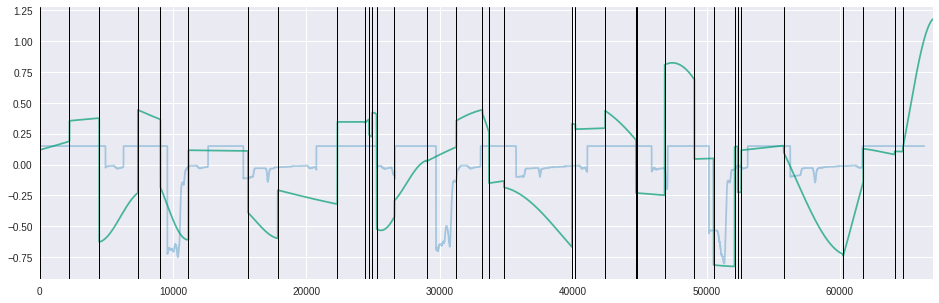

In [18]:
plt.figure(figsize=(16, 5))
plt.plot(tutor_params[:, 1], alpha=0.3)
plt.plot(ab[:, 1], alpha=0.7)
plt.xlim(0, ab.shape[0])
for i, gesture in enumerate(smodels[0].gestures):
    start = gesture[0]
    plt.axvline(x=start, color="k", linewidth=1)

In [19]:
gtes = np.loadtxt('../data/{}_gte.dat'.format(basename(run_param['tutor']).split('.')[0]))
true_gtes = gtes[np.concatenate(((np.diff(gtes) > 100), (False,)))]

In [20]:
plt.figure(figsize=(16, 5))
plt.plot(np.arange(28000, 35000), tutor_params[28000:35000])
#plt.plot(ab[:, 0], alpha=0.5)
plt.xlim(28000, 35000)
plt.xticks([])
plt.yticks([])
for gte in true_gtes:
    start = gesture[0]
    plt.axvline(x=gte, color="k", linewidth=1)

In [21]:
len(true_gtes)

65

In [22]:
np.mean(np.diff(true_gtes))

881.453125

In [23]:
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
ax.set_xlim(0, ab.shape[0]/40)
for gte in true_gtes:
    ax.axvline(x=gte/40, color="k", linewidth=1)

# Analysis of the song log

In [24]:
try:
    with open(join(path, 'data.pkl'), 'rb') as f:
        songlog = pickle.load(f)
except FileNotFoundError:
    warnings.warn('warning, learning not over')
    with open(join(path, 'data_cur.pkl'), 'rb') as f:
        songlog = pickle.load(f)

/home/ecoffet/.virtualenvs/birdsongs/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: warning, learning not over


In [25]:
root_data = [item[1] for item in songlog if item[0] == 'root']
rd = pandas.DataFrame(root_data)

In [26]:
day_opt = pandas.DataFrame([elem[1] for elem in songlog if elem[0] == 'day_optim'])

In [27]:
score_array = np.array([list(a) for a in rd['scores']]).T

plt.figure(figsize=(16, 5))
for i in range(1, len(rd['scores']), 2):
    plt.axvspan(i, i+1, facecolor='darkblue', alpha=0.1)
sns.tsplot(score_array, err_style='unit_traces')
#plt.xticks(range(len(rd['scores'])), rd['moment'], rotation=75)
plt.show()

In [28]:
best = np.argmax(rd['scores'].iloc[-1])
best

0

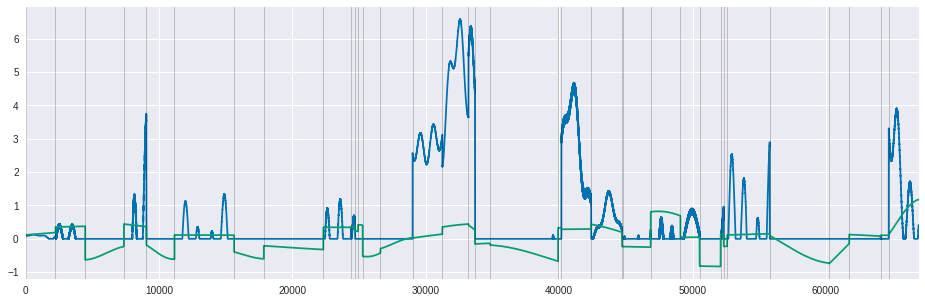

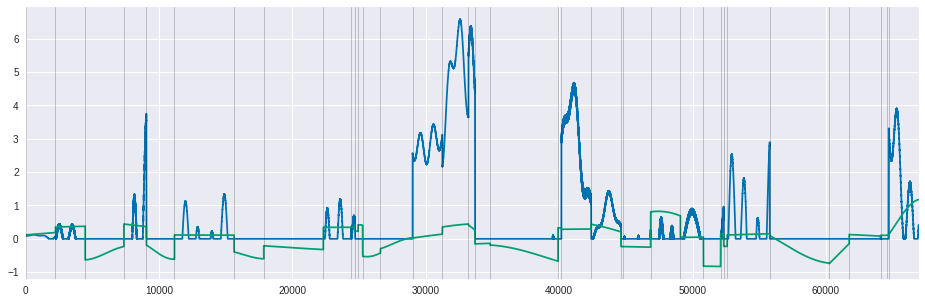

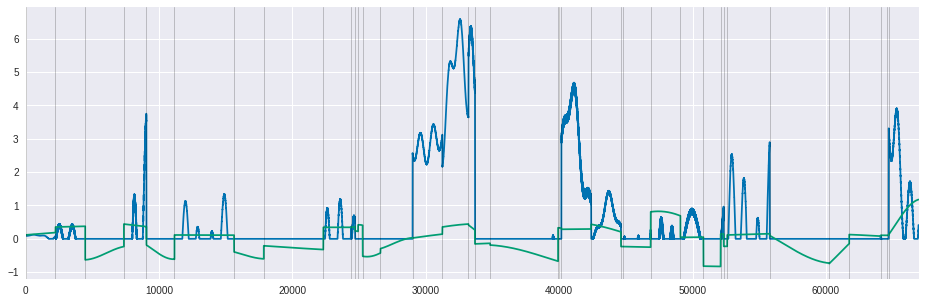

In [29]:
tutor_params = np.loadtxt('../data/{}_ab.dat'.format(basename(run_param['tutor']).split('.')[0]))

for i in range(len(rd['songs'].iloc[-1])):
    plt.figure(figsize=(16, 5))
    ab = rd['songs'].iloc[-1][i].gen_alphabeta()
    plt.plot(ab)
    plt.xlim((0, ab.shape[0]))
    #plt.yticks([], [])
    for gesture in rd['songs'].iloc[-1][i].gestures:
        start = gesture[0]
        plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
plt.figure(figsize=(16,5))
plt.plot(tutor_params)
plt.xlim((0, ab.shape[0]))
for gesture in rd['songs'].iloc[-1][i].gestures:
    start = gesture[0]
    plt.axvline(x=start, color="k", linewidth=1, alpha=0.2)
plt.show()

(0, 66932)

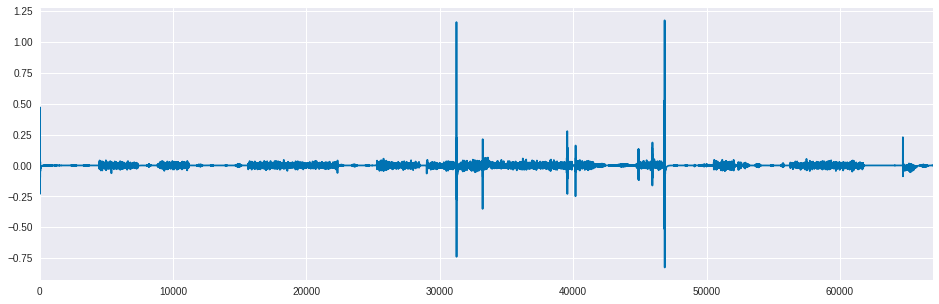

In [30]:
plt.figure(figsize=(16, 5))
s = rd['songs'].iloc[-1][best].gen_sound(fixed_normalize=False)
plt.plot(s)
#plt.yticks([], [])
plt.xlim((0, len(s)))

### Learned

### Tutor

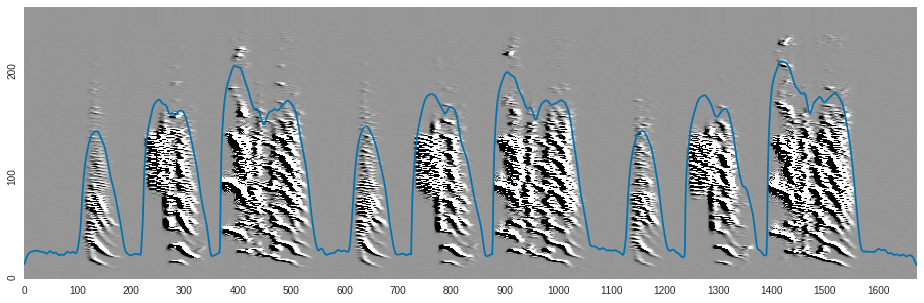

### Synthesized

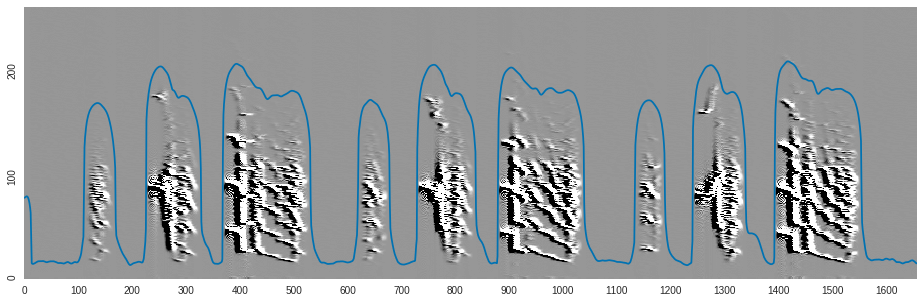

In [31]:
ab = rd['songs'].iloc[-1][best].gen_alphabeta()
s = synthesize(ab, fixed_normalize=False)

display(Markdown('### Learned'))
display(Audio(s, rate=44100))
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
bsa.spectral_derivs_plot(bsa.spectral_derivs(s, 256, 40, 1024), contrast=0.001, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(s, 256, 40, 1024), ax=ax)
plt.show()

display(Markdown('### Tutor'))
display(Audio(tutor, rate=44100))
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
bsa.spectral_derivs_plot(bsa.spectral_derivs(tutor, 256, 40, 1024), contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(tutor, 256, 40, 1024), ax=ax)
plt.show()

display(Markdown('### Synthesized'))
ts = synthesize(tutor_params)
display(Audio(ts, rate=44100))
fig = plt.figure(figsize=(16, 5))
ax = fig.gca()
bsa.spectral_derivs_plot(bsa.spectral_derivs(ts, 256, 40, 1024), contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(ts, 256, 40, 1024), ax=ax)
plt.show()

In [32]:
from ipywidgets import widgets

In [33]:
textarea = widgets.Textarea()
try:
    with open(join(path, 'notes.md')) as f:
        textarea.value = f.read()
except FileNotFoundError:
    pass
display(textarea)
button = widgets.Button(description="Save!")
display(button)

def on_button_clicked(b):
    with open(join(path, 'notes.md'), 'w') as f:
        f.write(textarea.value)
    print('saved')

button.on_click(on_button_clicked)


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.
